In [1]:
import os
import pickle
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.inspection import permutation_importance

warnings.filterwarnings('ignore')

plt.style.use('seaborn-whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
DATADIR = os.path.join(os.getcwd(), 'data', 'GBRT')

features = ['priorProb', 'entityPrior', 'maxPriorProb', 'numCands',
            'editDist', 'mentionIsCand', 'mentionInCand', 'isStartorEnd',
            'contextSim', 'coherence', 'rank']

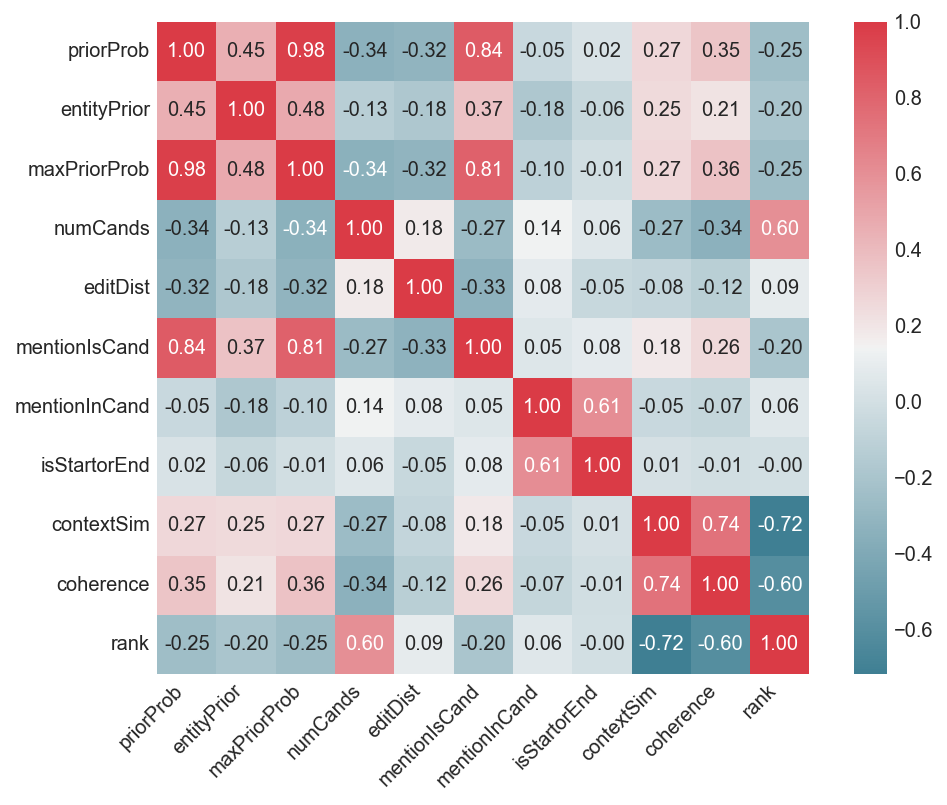

In [3]:
df = pd.read_csv("./data/GBRT/wiki2vec_w10_100d.pkl_train.csv")
f, ax = plt.subplots(figsize=(8, 6))
corr = df[features].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, annot=True, fmt='.2f', ax=ax)
plt.xticks(rotation=45, ha='right')
plt.show()

In [4]:
def load_model(fname):
    model = None
    with open(os.path.join(DATADIR, fname), 'rb') as f:
        model = pickle.load(f)
    return model


def plot_feat_importance(model, X, num_samples=5000):
    n = model.n_features_
    X = X.sample(num_samples)
    X_test, y_test = X[features[:n]], X['y']

    fig, ax = plt.subplots(figsize=(6, 4))
    feat_importances = pd.Series(model.feature_importances_, index=features[:n])
    feat_importances.plot.bar(ax=ax)
    ax.set_title("Feature importance")
    ax.set_ylabel("Feature")
    ax.set_xticklabels(features[:n], rotation=45, ha='right', rotation_mode='anchor')
    fig.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(6, 4))
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
    perm_importances = pd.Series(result.importances_mean, index=features[:n])
    perm_importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title("Feature importances using permutation")
    ax.set_ylabel("Mean accuracy decrease")
    ax.set_xticklabels(features[:n], rotation=45, ha='right', rotation_mode='anchor')
    fig.tight_layout()
    plt.show()

    explainer = shap.TreeExplainer(model=model, data=None, model_output='raw',
                                   feature_perturbation='tree_path_dependent')
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, features=X_test)

wiki2vec_w10_100d.pkl


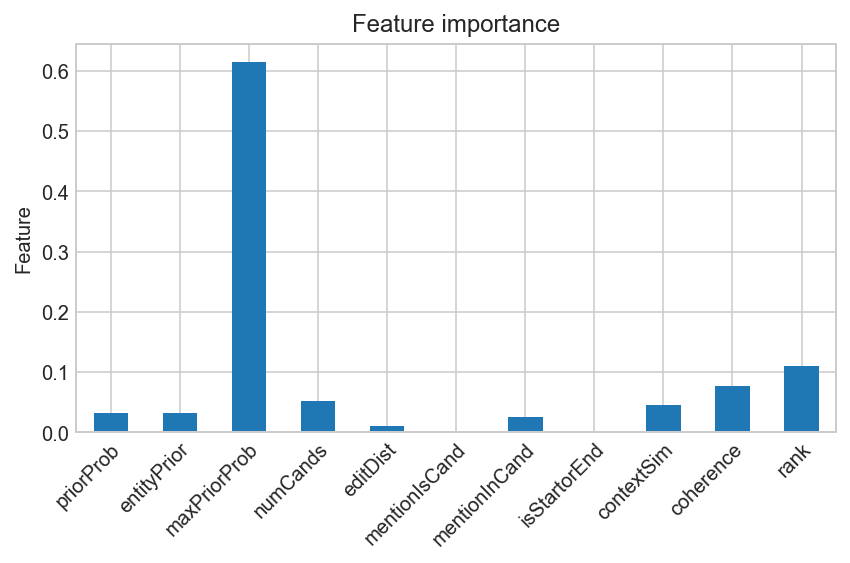

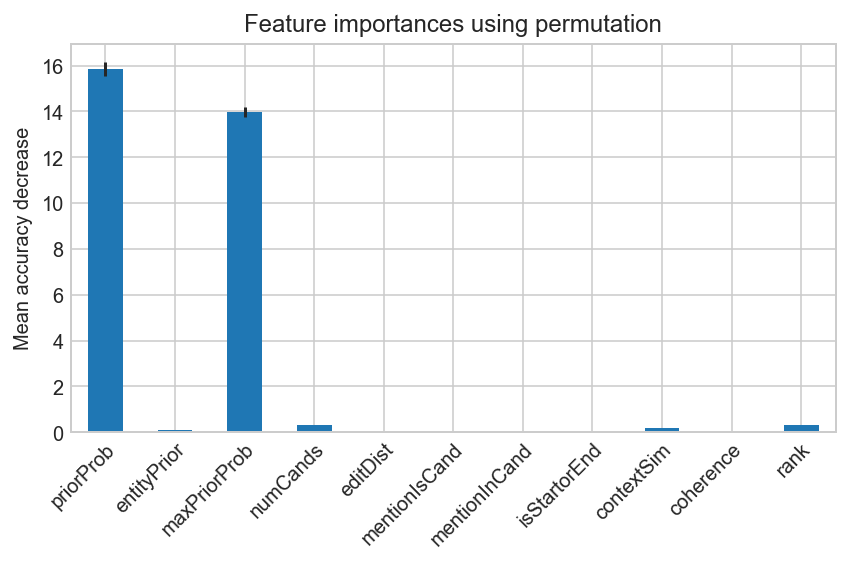

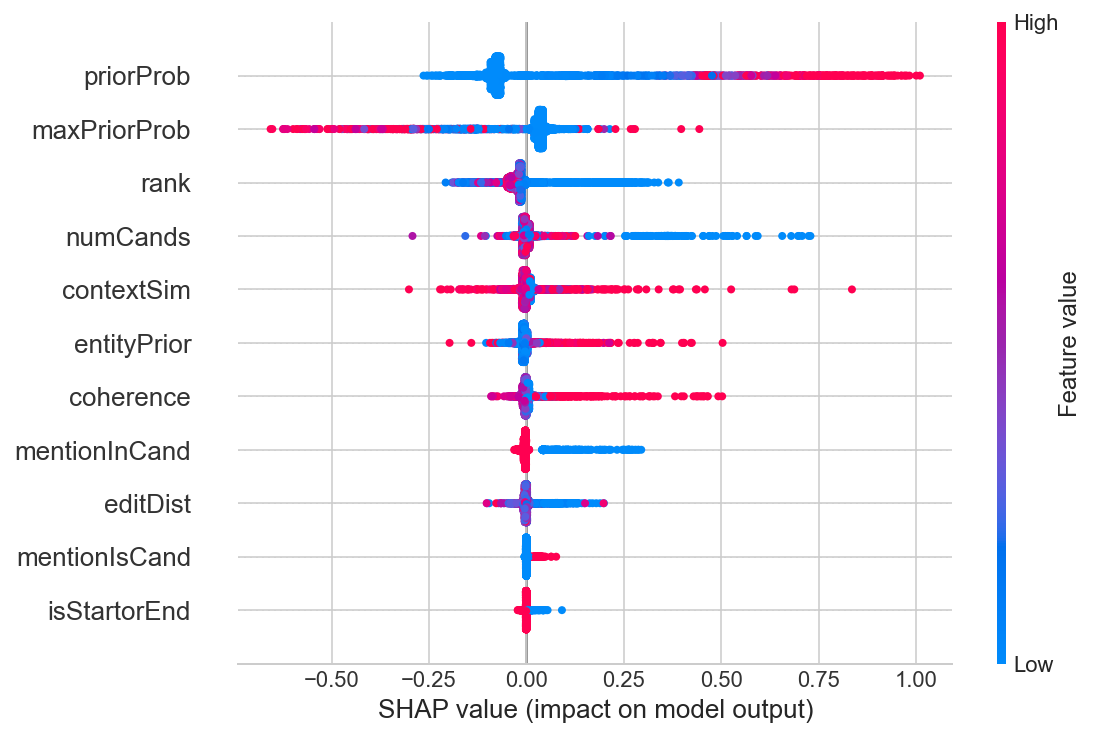

wiki2vec_w10_300d.pkl


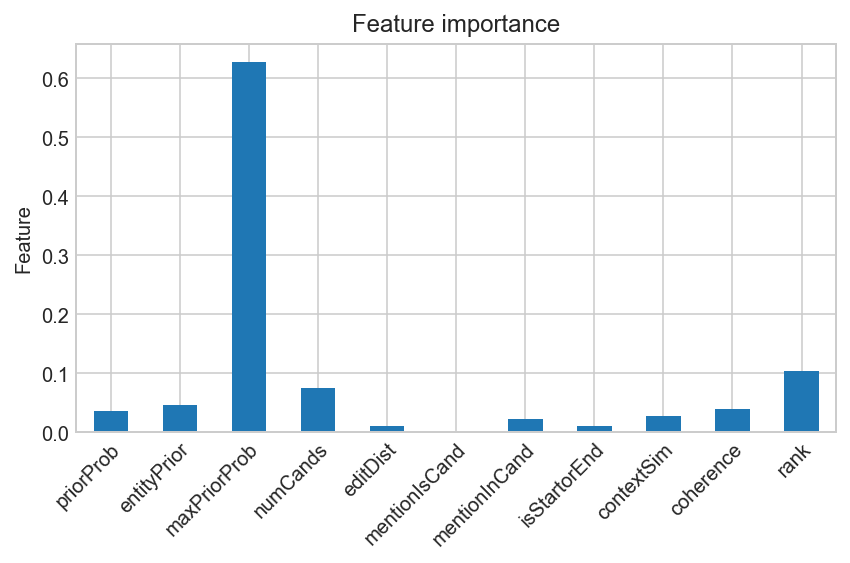

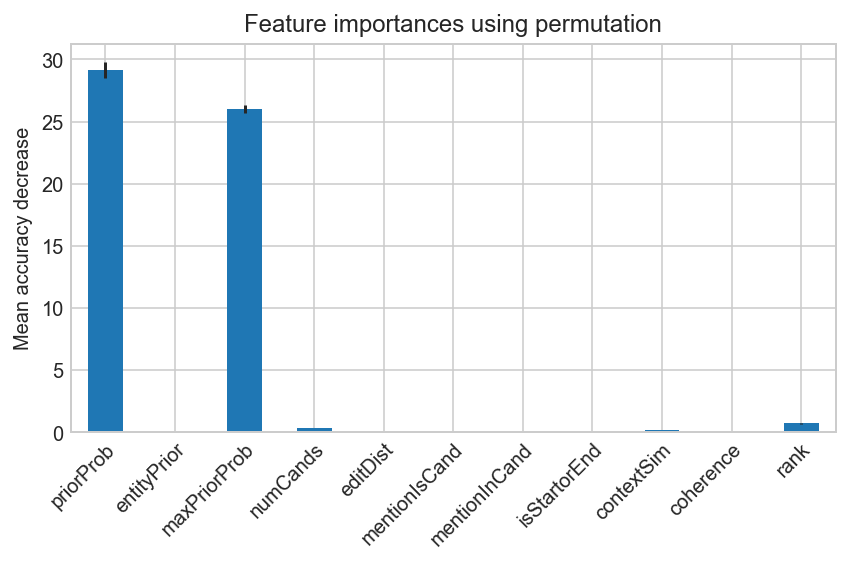

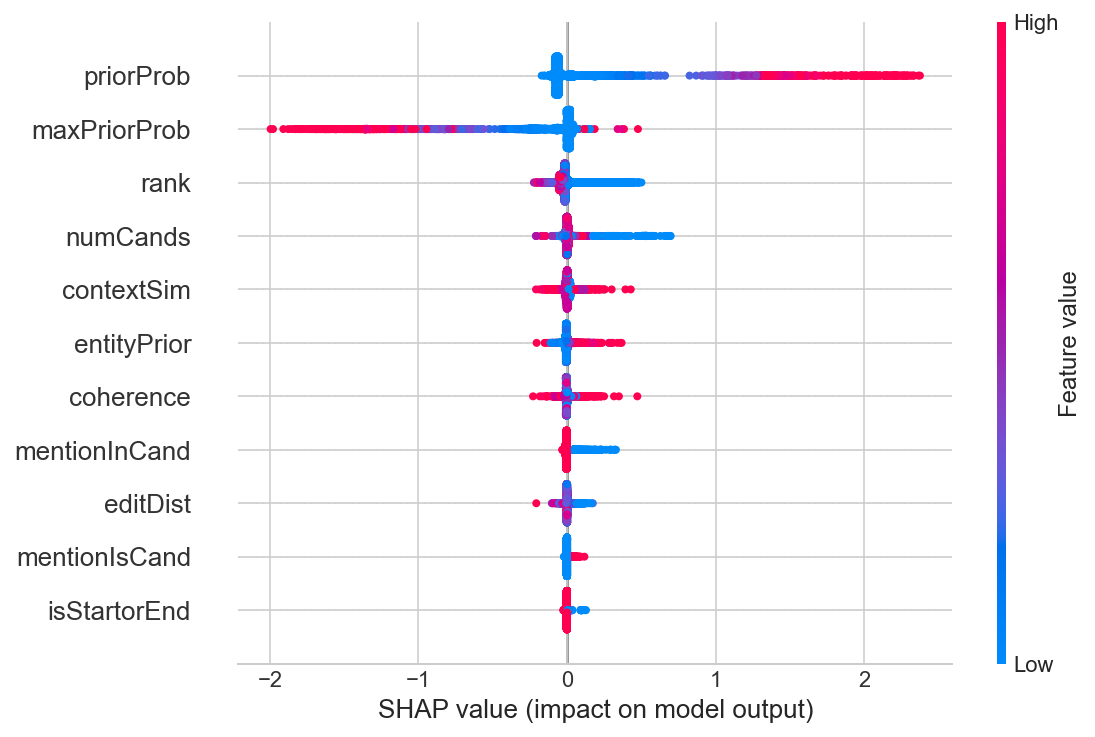

word2vec-google-news-300


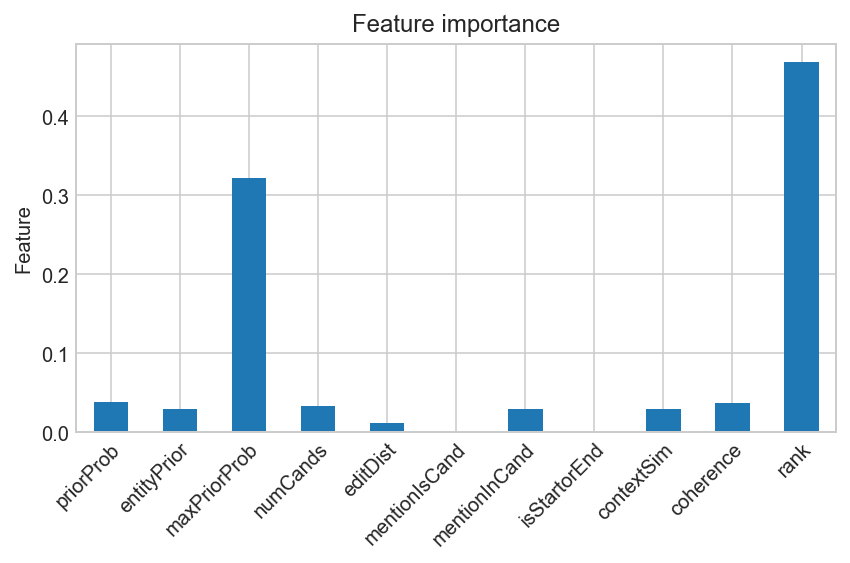

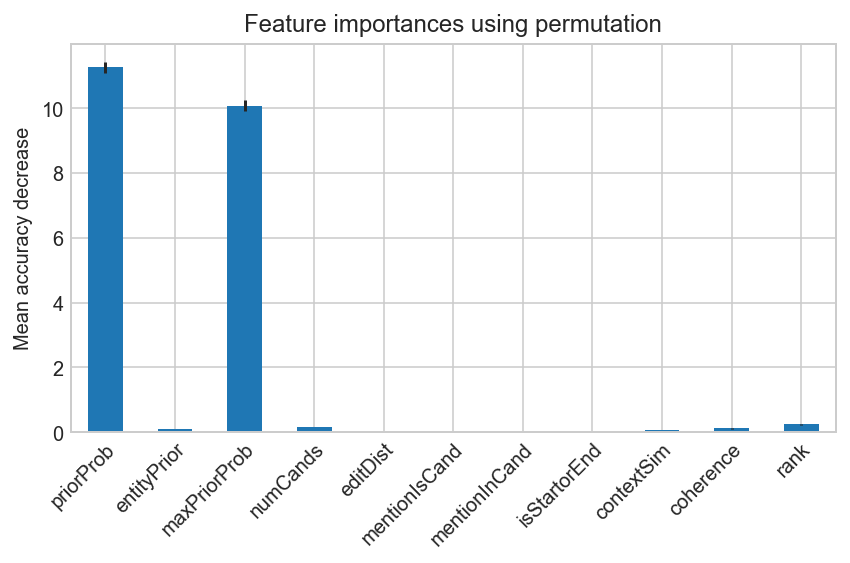

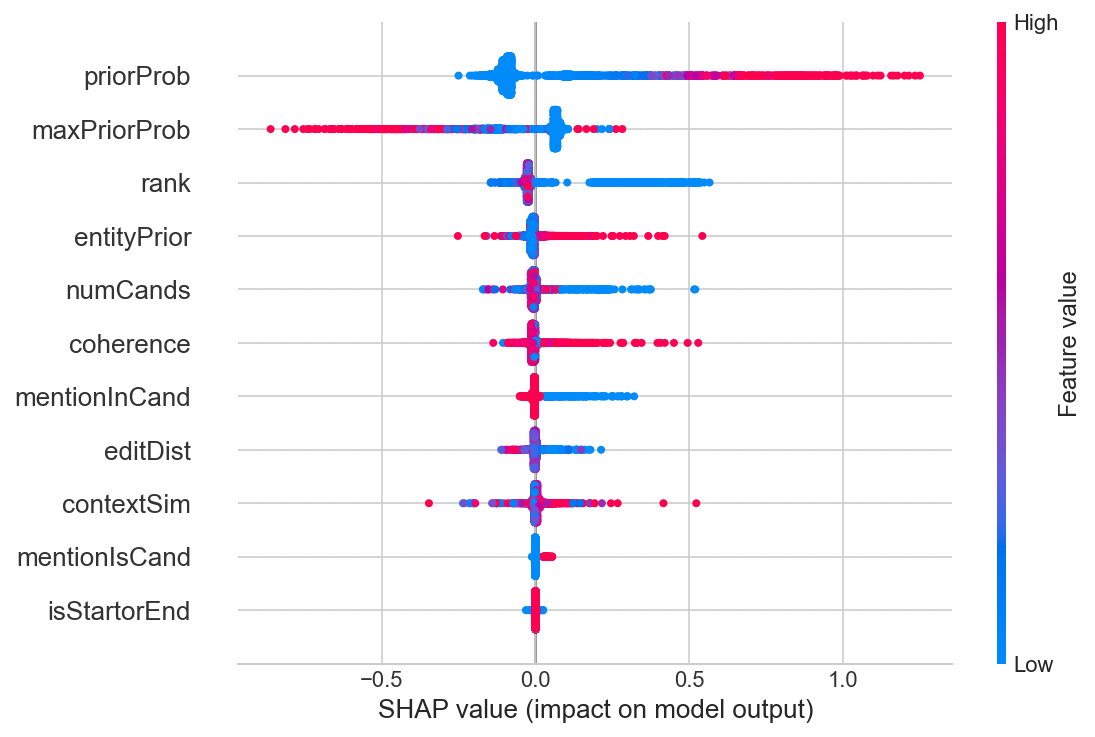

glove-wiki-gigaword-300


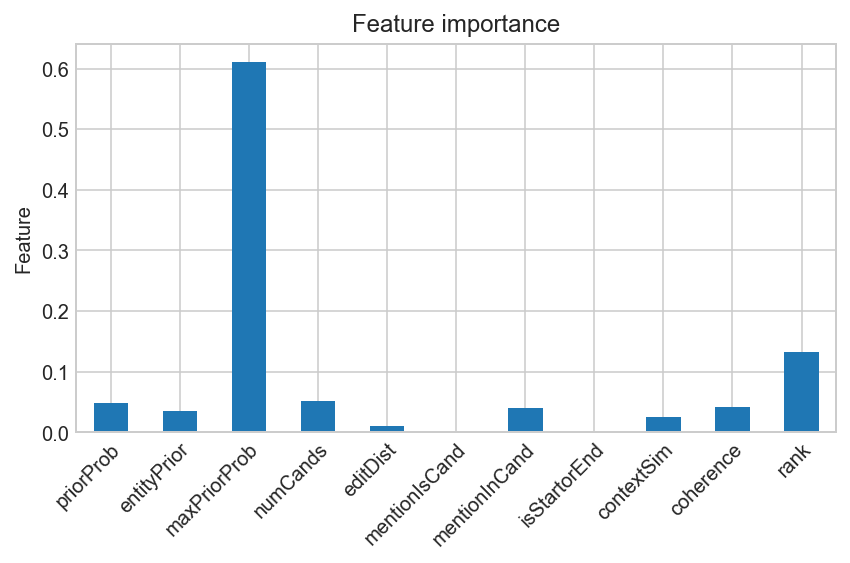

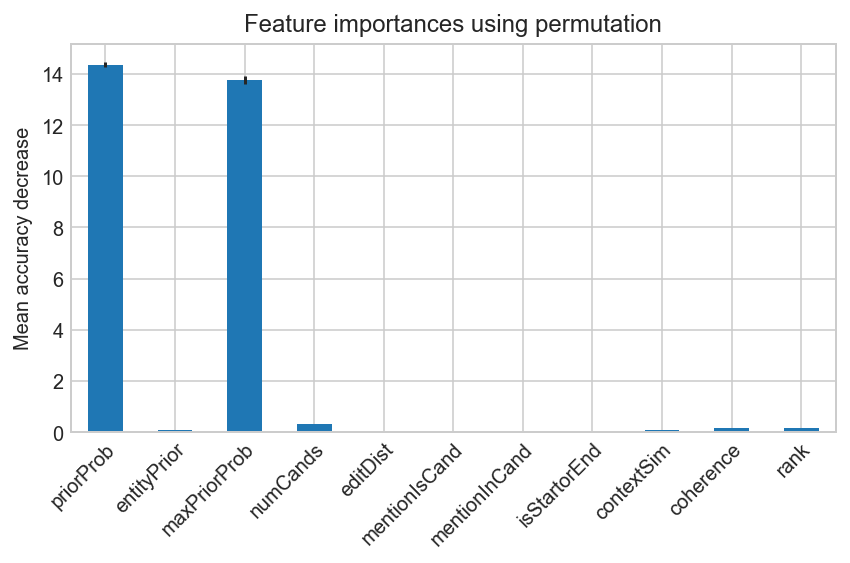

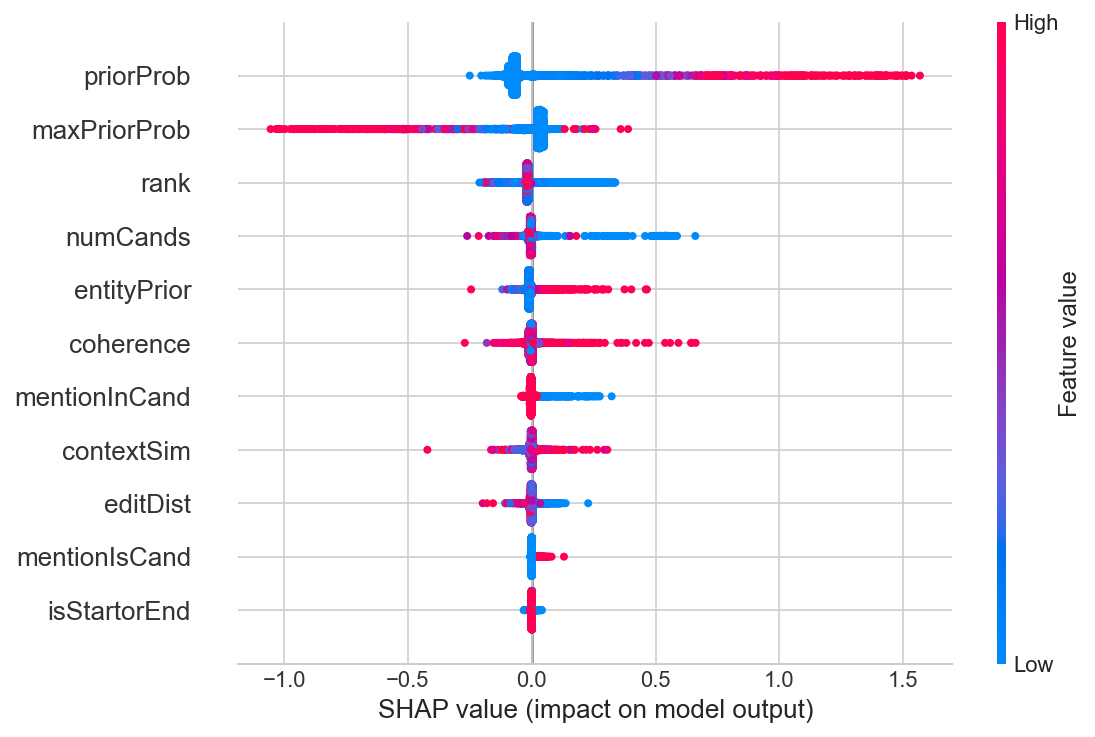

fasttext-wiki-news-subwords-300


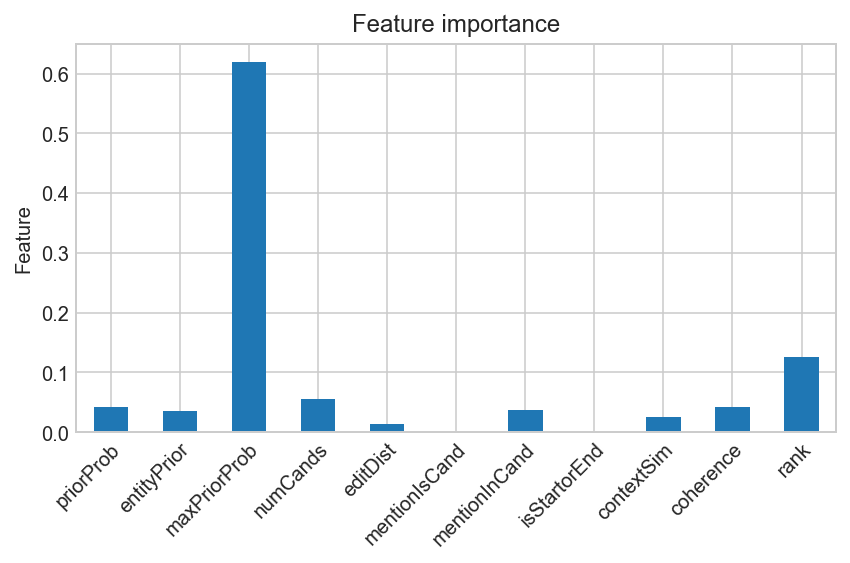

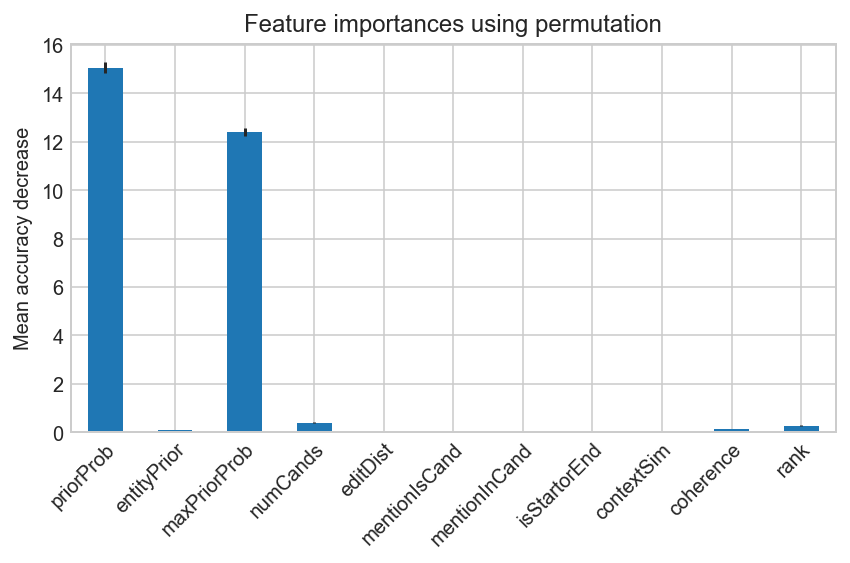

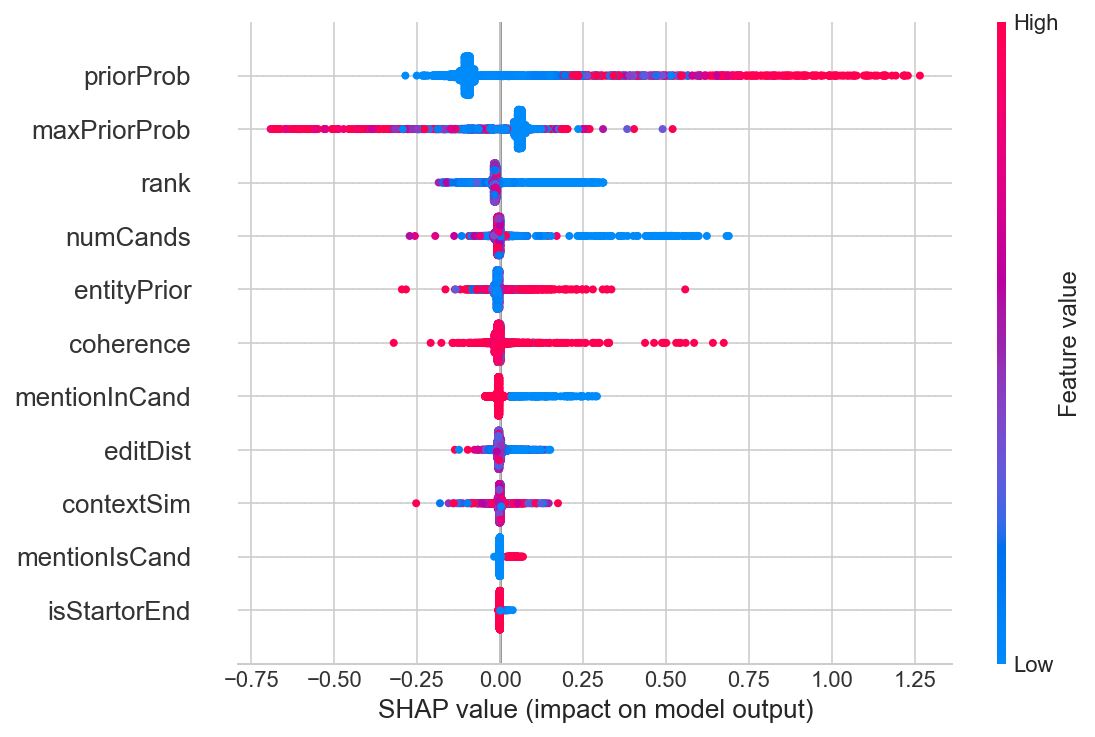

TRF


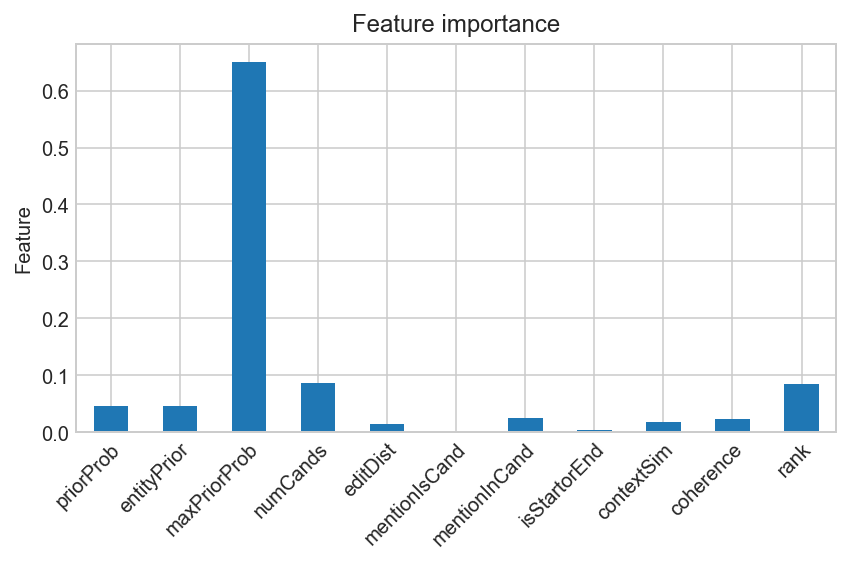

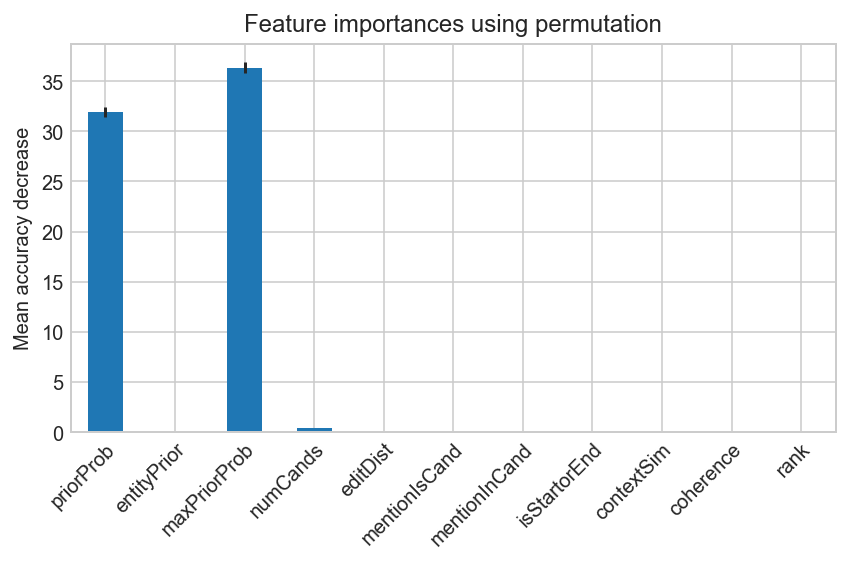

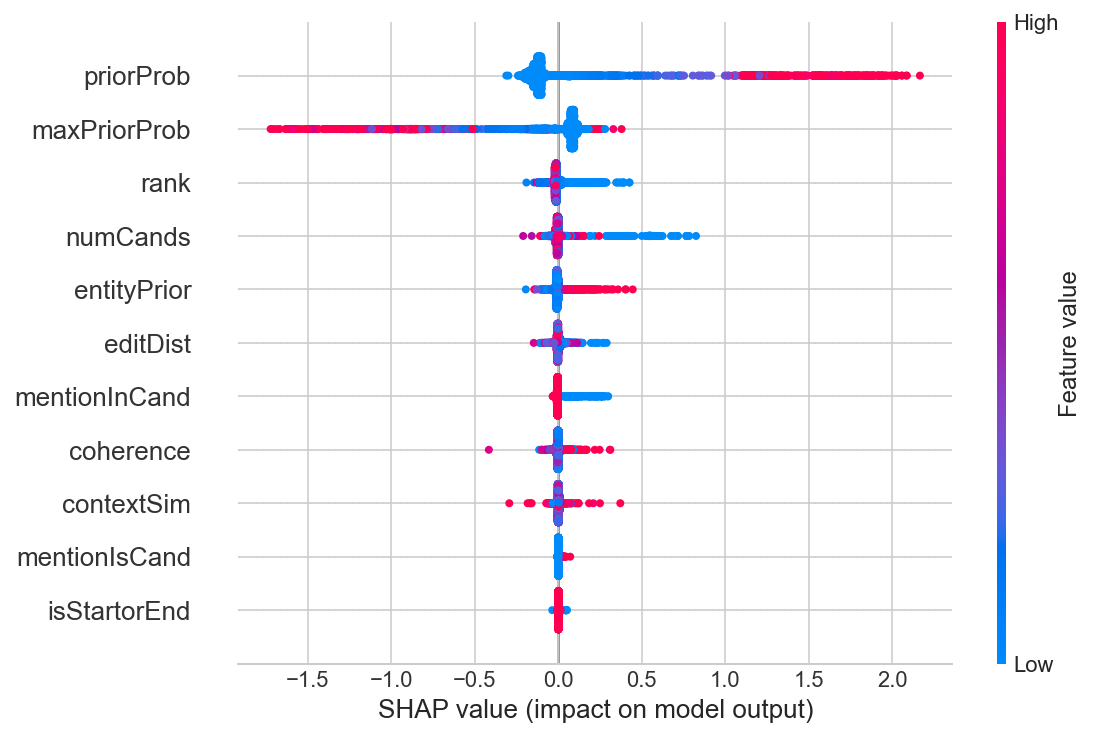

In [5]:
embs  = ["wiki2vec_w10_100d.pkl", "wiki2vec_w10_300d.pkl", 
         "word2vec-google-news-300", "glove-wiki-gigaword-300",
         "fasttext-wiki-news-subwords-300", "TRF"]

for emb in embs:
    print(emb)
    df_test = pd.read_csv(f"./data/GBRT/{emb}_train.csv")
    model   = load_model(os.path.join(DATADIR, emb + '_trained.pkl'))
    plot_feat_importance(model, df_test)